In [12]:
import xarray as xr 
import numpy as np
import math 
import glob
import s3fs 
import warnings 
import matplotlib.pyplot as plt
import xgcm

In [2]:
def open_s3fs(path):
    # open the data with s3fs from the databucket 
    fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
    data_path = f's3://data/{path}/*'
    remote_files = fsg.glob(data_path)
    fileset = [fsg.open(file) for file in remote_files]
    #open the dataset 
    dset = xr.open_mfdataset(fileset, combine='by_coords',compat='override')
    # rename variabel
    dset = dset.rename({'__xarray_dataarray_variable__' : 'vel'})
    return dset

In [3]:
# open the data with s3fs from the databucket 
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
data_path1 = 's3://velocity-u.zarr/'
data_path2 = 's3://velocity-v.zarr/'
remote_files1 = fsg.glob(data_path1)
remote_files2 = fsg.glob(data_path2)

store1 = s3fs.S3Map(root=data_path1, s3=fsg, check=False)
store2 = s3fs.S3Map(root=data_path2, s3=fsg, check=False)
du = xr.open_zarr(store=store1, consolidated=True)
du = du.rename({'depthu' : 'depth'})
dv = xr.open_zarr(store=store2, consolidated=True)
dv = dv.rename({'depthv' : 'depth'})

In [4]:
ds = open_s3fs('PC-data')
ds

<xarray.Dataset>
Dimensions:        (depth: 75, x: 1580, y: 1801)
Coordinates:
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_centered  object ...
    time_counter   object ...
    nav_lat        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
Dimensions without coordinates: x, y
Data variables:
    vel            (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    mbathy         (y, x) int16 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    vomecrty       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    vozocrtx       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>

In [5]:
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })

fsg.ls('s3://data')
data_path = f's3://data/CREG12.L75-REF08_mesh_hgr.nc'
remote_files = fsg.glob(data_path)
fileset = [fsg.open(file) for file in remote_files]
dm = xr.open_mfdataset(fileset, combine='by_coords',compat='override')
dm

<xarray.Dataset>
Dimensions:       (t: 1, x: 1580, y: 1801, z: 75)
Dimensions without coordinates: t, x, y, z
Data variables: (12/21)
    nav_lon       (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lev       (z) float32 dask.array<chunksize=(75,), meta=np.ndarray>
    time_counter  (t) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    glamt         (t, y, x) float32 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    glamu         (t, y, x) float32 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    ...            ...
    e1f           (t, y, x) float64 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    e2t           (t, y, x) float64 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    e2u           (t, y, x) float64 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    e2v           (t, y, x) float64 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    e2f           (t, y, x) float64 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    ff            (t, y, x) float64 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
Attributes:
    file_name:  mesh_hgr.nc
    TimeStamp:  06/06/2019 11:25:45 +0200

In [6]:
d = ds.mbathy.isel(y=slice(900,1800), x=slice(200,1400))

In [7]:
delta_dx = d.isel(y=slice(0,899)).diff(dim='x')
delta_dy = d.isel(x=slice(0,1199)).diff(dim='y')

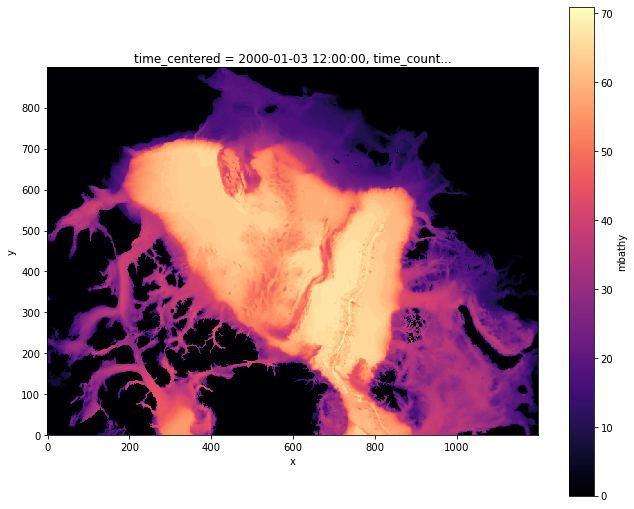

In [8]:
fig, ax = plt.subplots(1,1,figsize=(11,9))
cmap_m = plt.get_cmap('magma')
d.plot(cmap=cmap_m)
ax.set_aspect('equal')

## Making grad_hb using glamu (u long) and gphiu (u lat)

In [9]:
d_zonal = dm.glamu.isel(y=slice(900,1799), x=slice(200,1399)).squeeze(axis=0)
d_merd = dm.gphiu.isel(y=slice(900,1799), x=slice(200,1399)).squeeze(axis=0)

In [10]:
grad_hb = (delta_dx/d_zonal) + (delta_dy/d_merd)

/opt/conda/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


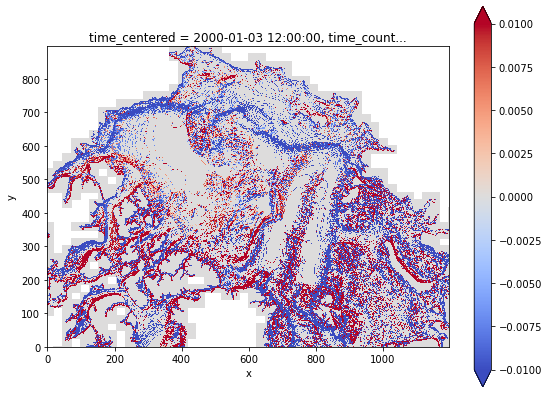

In [11]:
fig, ax = plt.subplots(1,1,figsize=(9,7))
cmap = plt.get_cmap('coolwarm')
c = grad_hb.plot(vmin=-0.01, vmax=0.01, cmap=cmap)
ax.set_aspect('equal')

In [41]:
grad_hb = grad_hb.fillna(0.)
grad_hb.values

/opt/conda/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [54]:
grad_hb = grad_hb.where(grad_hb == np.isfinite).fillna(0.)

In [55]:
grad_hb.values

/opt/conda/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### U_ortogonal & U_parallell

In [56]:
u = du.vozocrtx.isel(y=slice(900,1799), x=slice(200,1399))
v = dv.vomecrty.isel(y=slice(900,1799), x=slice(200,1399))
print(u.shape, v.shape)

(73, 75, 899, 1199) (73, 75, 899, 1199)


In [57]:
vel_ort = u*(d_zonal/delta_dx) + v*(d_merd/delta_dy)
#vel_ort = np.nan_to_num(vel_ort) --> denne får ting til å kræsje 

In [58]:
vel_par = u*(d_merd/delta_dy) - v*(d_zonal/delta_dx)
#vel_par = np.nan_to_num(vel_par) også får ting til å kræsje 

In [17]:
a = xr.ufuncs.isfinite(vel_ort).any()
print(a)

<xarray.DataArray ()>
dask.array<any-aggregate, shape=(), dtype=bool, chunksize=(), chunktype=numpy.ndarray>


In [21]:
print(vel_ort.shape)
vel_ort[0,0,:,0].shape

(73, 75, 899, 1199)


(899,)

### Visulizing 

In [59]:
punkt_list = [(500,500), (650,300), (870,600), (820,200), (520,350)]

500 500
650 300
870 600
820 200
520 350


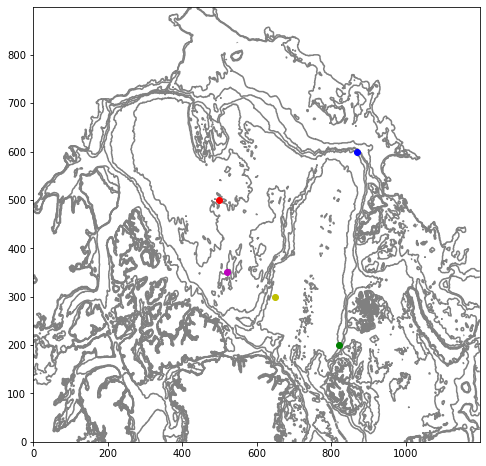

In [60]:
fig, axs = plt.subplots(1,1,figsize=(8,8))
c_list = ['r', 'y', 'b', 'g', 'm']
axs.contour(d, colors = 'grey')

for p in range(len((punkt_list))):
    
    pp = punkt_list[p]
    print(pp[0], pp[1]) 
    axs.plot(pp[0],pp[1] ,marker = 'o' ,color = c_list[p])

Ortogonal 

In [61]:
def PCz(x,y):
    'Finding the level the given location dosent have values for anymore'
    
    d = ds.mbathy.isel(y=y, x=x).values
    dyp = vel_ort.isel(x=x, y=y, depth = slice(0,d-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
    
    cov = np.cov(dyp.T, bias=True) # uten .T ble den en 73x73 matrise 
    values, vectors = np.linalg.eig(cov)
    order = values.argsort()[::-1]
    values, vectors = values[order], vectors[:, order]
    
    return  values, vectors, dyp

500 500


LinAlgError: Array must not contain infs or NaNs

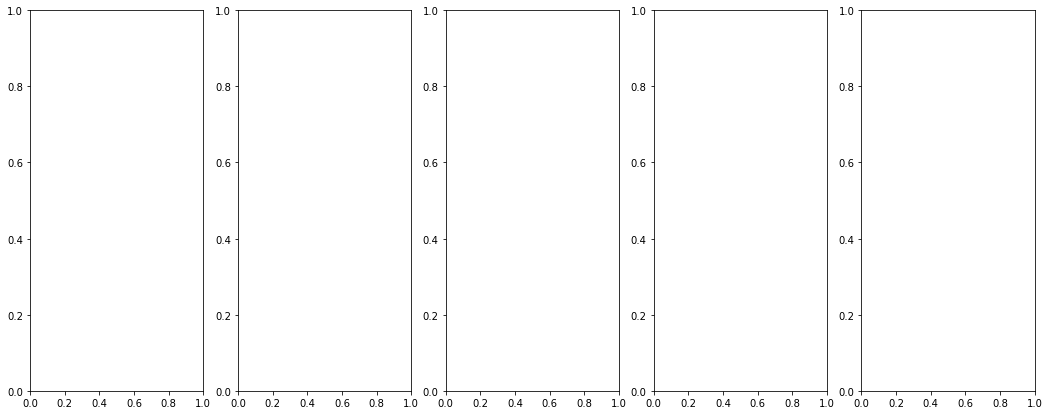

In [62]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,5,figsize = (18,7))

for axs, p in zip(axes.flat, range(len((punkt_list)))):
    pp = punkt_list[p]
    print(pp[0], pp[1])    
    values, vectors, dyp = PCz(pp[0],pp[1])
        
    axs.plot(vectors[:,0]*np.sqrt(values[0]),dyp.depth, 'k')
    axs.plot(vectors[:,1]*np.sqrt(values[1]),dyp.depth, 'b')
    axs.plot(vectors[:,2]*np.sqrt(values[2]),dyp.depth, 'g')
    axs.axvline(0, color='r', linestyle = '--')
    axs.invert_yaxis()

Parallell 

In [ ]:
def PCz(x,y):
    'Finding the level the given location dosent have values for anymore'
    
    d = ds.mbathy.isel(y=y, x=x).values
    dyp = vel_par.isel(x=x, y=y, depth = slice(0,d-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
    
    cov = np.cov(dyp.T, bias=True) # uten .T ble den en 73x73 matrise 
    values, vectors = np.linalg.eig(cov)
    order = values.argsort()[::-1]
    values, vectors = values[order], vectors[:, order]
    
    return  values, vectors, dyp

In [ ]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,5,figsize = (18,7))
ax.set_title('Vel_parallell')

for axs, p in zip(axes.flat, range(len((punkt_list)))):
    pp = punkt_list[p]
    print(pp[0], pp[1])    
    values, vectors, dyp = PCz(pp[0],pp[1])
        
    axs.plot(vectors[:,0]*np.sqrt(values[0]),dyp.depth, 'k')
    axs.plot(vectors[:,1]*np.sqrt(values[1]),dyp.depth, 'b')
    axs.plot(vectors[:,2]*np.sqrt(values[2]),dyp.depth, 'g')
    axs.axvline(0, color='r', linestyle = '--')
    axs.invert_yaxis()

## 20 m down 

In [69]:
def PCz_20(x,y):
    'Finding the level the given location dosent have values for anymore'
    
    d = ds.mbathy.isel(y=y, x=x).values
    dyp = vel_ort.isel(x=x, y=y, depth = slice(15,d-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
    
    cov = np.cov(dyp.T, bias=True) # uten .T ble den en 73x73 matrise 
    values, vectors = np.linalg.eig(cov)
    order = values.argsort()[::-1]
    values, vectors = values[order], vectors[:, order]
    
    return  values, vectors, dyp

500 500


KeyboardInterrupt: 

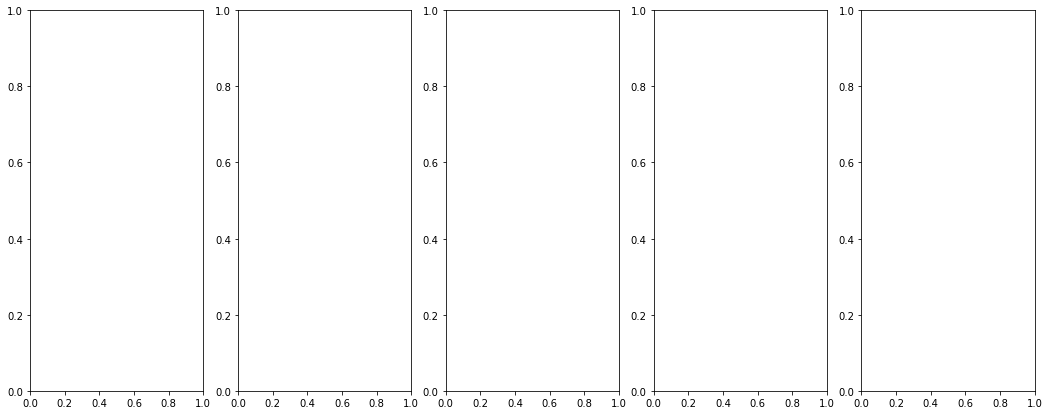

In [70]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,5,figsize = (18,7))
ax.set_title('Vel_ortogonal, without the first 20m')

for axs, p in zip(axes.flat, range(len((punkt_list)))):
    pp = punkt_list[p]
    print(pp[0], pp[1])    
    values, vectors, dyp = PCz_20(pp[0],pp[1])
        
    axs.plot(vectors[:,0]*np.sqrt(values[0]),dyp.depth+22, 'k')
    axs.plot(vectors[:,1]*np.sqrt(values[1]),dyp.depth+22, 'b')
    axs.plot(vectors[:,2]*np.sqrt(values[2]),dyp.depth+22, 'g')
    axs.axvline(0, color='r', linestyle = '--')
    axs.invert_yaxis()

In [ ]:
def PCz_20(x,y):
    'Finding the level the given location dosent have values for anymore'
    
    d = ds.mbathy.isel(y=y, x=x).values
    dyp = vel_par.isel(x=x, y=y, depth = slice(15,d-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
    
    cov = np.cov(dyp.T, bias=True) # uten .T ble den en 73x73 matrise 
    values, vectors = np.linalg.eig(cov)
    order = values.argsort()[::-1]
    values, vectors = values[order], vectors[:, order]
    
    return  values, vectors, dyp

In [ ]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,5,figsize = (18,7))
ax.set_title('Vel_parallell, without the first 20m')

for axs, p in zip(axes.flat, range(len((punkt_list)))):
    pp = punkt_list[p]
    print(pp[0], pp[1])    
    values, vectors, dyp = PCz_20(pp[0],pp[1])
        
    axs.plot(vectors[:,0]*np.sqrt(values[0]),dyp.depth+22, 'k')
    axs.plot(vectors[:,1]*np.sqrt(values[1]),dyp.depth+22, 'b')
    axs.plot(vectors[:,2]*np.sqrt(values[2]),dyp.depth+22, 'g')
    axs.axvline(0, color='r', linestyle = '--')
    axs.invert_yaxis()